# Fastembed - Embed and Store Images with Labels in Qdrant

In [138]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
#!pip install qdrant-client fastembed

In [140]:
#!python3.12 -m ipykernel install --user --name python3.12 --display-name "Python 3.12"


In [141]:
#!python3.12 -m pip install ipykernel

In [142]:
import sys
print(sys.version)

3.12.3 (main, Jun  3 2024, 12:49:48) [GCC 11.4.0]


In [143]:
!tree -L 2

.
├── env
│   ├── bin
│   ├── lib
│   └── pyvenv.cfg
├── Fast_Embed_Images.ipynb
├── fmb
│   ├── bin
│   ├── lib
│   └── pyvenv.cfg
└── images_dataset
    ├── human
    ├── not_human
    └── users_image

10 directories, 3 files


In [144]:
from qdrant_client import QdrantClient, models
from fastembed import ImageEmbedding
from qdrant_client.models import PointStruct, VectorParams, Distance
import os
from PIL import Image

# Initialize the Qdrant client
client = QdrantClient("http://localhost:6333")

In [145]:

# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Directories for human and not human images
root_dir = 'images_dataset'

# Collect image paths and labels
for label_dir in ['human', 'not_human']:
    label_path = os.path.join(root_dir, label_dir)
    for subdir, _, files in os.walk(label_path):
        for file in files:
            if file.lower().endswith(".jpg"):
                image_paths.append(os.path.join(subdir, file))
                labels.append(label_dir)

In [146]:
# Initialize the ImageEmbedding model
model = ImageEmbedding(model_name="Qdrant/clip-ViT-B-32-vision")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [147]:
# Generate embeddings
embeddings = list(model.embed(image_paths))

## Create Qdrant collection

In [148]:
# Create Qdrant collection
collection_name = "image_classification"
client.delete_collection(collection_name)
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=len(embeddings[0]), distance=Distance.COSINE)
)


True

## Insert points into Qdrant

In [149]:
# Insert points into Qdrant
points = [
    PointStruct(id=idx, vector=embedding, payload={"path": image_paths[idx], "label": labels[idx]})
    for idx, embedding in enumerate(embeddings)
]
client.upsert(collection_name=collection_name, points=points)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [1]:
#points

In [2]:
from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct, VectorParams, Distance
from fastembed import ImageEmbedding
import os
from PIL import Image

# Initialize the ImageEmbedding model
model = ImageEmbedding(model_name="Qdrant/clip-ViT-B-32-vision")

# Initialize the Qdrant client
client = QdrantClient("http://localhost:6333")

def classify_new_image(image_path):
    # Embed the new image
    new_image_embedding = list(model.embed([image_path]))[0]  # Convert generator to list and access the first item

    # Search for the closest match in the Qdrant collection
    collection_name = "image_classification"
    search_result = client.search(
        collection_name=collection_name,
        query_vector=new_image_embedding,
        limit=1  # We only need the closest result
    )

    # Extract the closest result
    if search_result:
        closest_result = search_result[0]
        closest_id = closest_result.id
        closest_label = closest_result.payload.get("label", "unknown")

        return closest_label
    else:
        return "unknown"

# Example of using the classify_new_image function
new_image_path = 'images_dataset/users_image/image27.jpg'
label = classify_new_image(new_image_path)
print(f"The new image is classified as: {label}")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

The new image is classified as: human


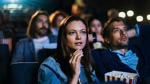

The new image is classified as: human


In [3]:
from PIL import Image
from IPython.display import display

# Load the image
new_image_path
image = Image.open(new_image_path)

# Optionally resize the image to create a thumbnail
thumbnail_size = (150, 150)  # Set the size of the thumbnail
image.thumbnail(thumbnail_size)

# Display the image
display(image)
print(f"The new image is classified as: {label}")